<a href="https://colab.research.google.com/github/AeAre/Animals_classification_with_CNN/blob/main/animals_classification_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 10 different animals classification using CNN

## Preparing dataset

In [1]:
# Downloading dataset in kaggle
!pip install opendatasets -q
import opendatasets as od
od.download("https://www.kaggle.com/datasets/alessiocorrado99/animals10/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: asd
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10


100%|██████████| 586M/586M [00:01<00:00, 400MB/s]


In [2]:
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel",
             "dog": "cane", "cavallo": "horse", "elephant" : "elefante", "butterfly": "farfalla", "chicken": "gallina", "cat": "gatto", "cow": "mucca", "spider": "ragno", "squirrel": "scoiattolo"}

In [3]:
import os

os.listdir('/content/animals10')

['translate.py', 'raw-img']

In [4]:
animal_dir = os.listdir('/content/animals10/raw-img')
animal_dir

['mucca',
 'farfalla',
 'cane',
 'scoiattolo',
 'gatto',
 'pecora',
 'cavallo',
 'gallina',
 'elefante',
 'ragno']

In [5]:
# moving all images and labels

images = []
labels = []

base_path = '/content/animals10/raw-img' # Define the base path

for folder_name in animal_dir: # Iterate directly over the list of folder names
  animals_path = os.path.join(base_path, folder_name) # Construct the full path to the animal's folder
  if os.path.isdir(animals_path):
    for animal_image_file in os.listdir(animals_path): # List files within that specific animal's folder
      images.append(os.path.join(animals_path, animal_image_file))
      if folder_name in translate:
        labels.append(translate[folder_name]) # Use folder_name for translation
      else:
        labels.append('spider') # explicitly state spider because of unknown error translate
print(f"Total images found: {len(images)}")
print(f"Total labels found: {len(labels)}")

Total images found: 26179
Total labels found: 26179


In [6]:
# Turn into dataframe
import pandas as pd

df = pd.DataFrame(
    {"filename": images,
     "label": labels}
)

df.head()

,filename,label
0,/content/animals10/raw-img/mucca/OIP-IvT29TqNX...,cow
1,/content/animals10/raw-img/mucca/OIP-Hjyzf-Om8...,cow
2,/content/animals10/raw-img/mucca/OIP-zruNXeVQQ...,cow
3,/content/animals10/raw-img/mucca/OIP-uD0INsqze...,cow
4,/content/animals10/raw-img/mucca/OIP-2alswI1Ju...,cow


In [7]:
df['label'].unique()

array(['cow', 'butterfly', 'dog', 'squirrel', 'cat', 'sheep', 'horse',
       'chicken', 'elephant', 'spider'], dtype=object)

In [8]:
df['label'].value_counts()

,count
label,
dog,4863
spider,4821
chicken,3098
horse,2623
butterfly,2112
cow,1866
squirrel,1862
sheep,1820
cat,1668


<Axes: title={'center': 'Number of images per label'}, xlabel='label'>

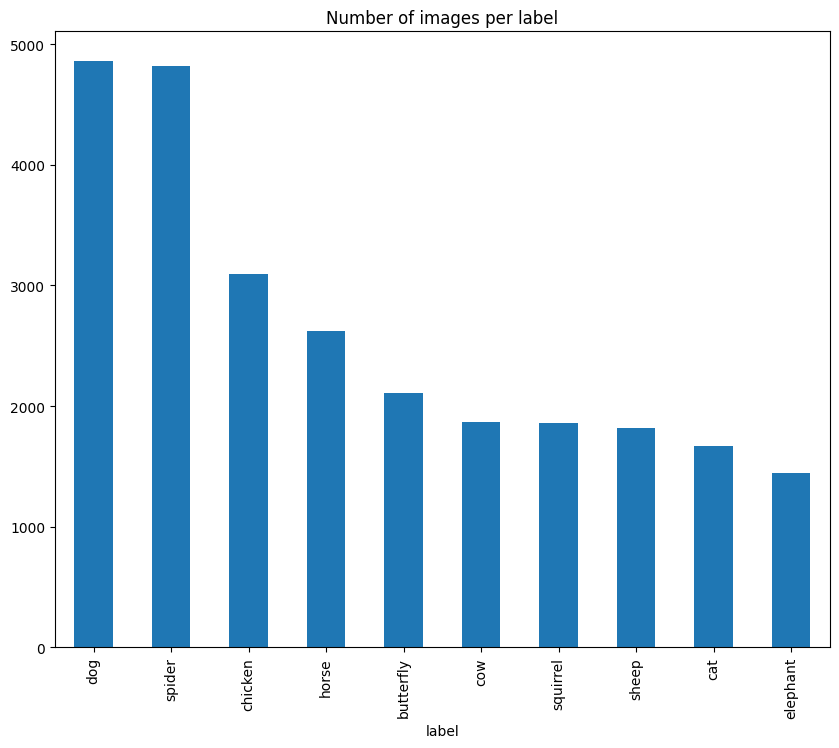

In [9]:
df['label'].value_counts().plot(kind='bar', figsize=(10, 8), title="Number of images per label")

### Splitting the dataset into train, val, and test set

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(df['filename'], df['label'], test_size=0.3, random_state=42, stratify=df['label'])

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Total training images: {len(X_train)}")
print(f"Total validation images: {len(X_val)}")
print(f"Total test images: {len(X_test)}")

Total training images: 18325
Total validation images: 3927
Total test images: 3927


In [11]:
train_df = pd.DataFrame({'filename': X_train, 'label': y_train})
val_df = pd.DataFrame({'filename': X_val, 'label': y_val})
test_df = pd.DataFrame({'filename': X_test, 'label': y_test})

train_df.head()

,filename,label
3616,/content/animals10/raw-img/farfalla/OIP-TXKjsm...,butterfly
10075,/content/animals10/raw-img/scoiattolo/OIP-K9j0...,squirrel
23899,/content/animals10/raw-img/ragno/OIP-BM4FasjHt...,spider
16365,/content/animals10/raw-img/cavallo/OIP-ISQw6bT...,horse
665,/content/animals10/raw-img/mucca/OIP--ojaB8xSP...,cow


### Visualizing some images

In [12]:
import matplotlib.pyplot as plt
import random
import seaborn as sns
import numpy as np
import cv2

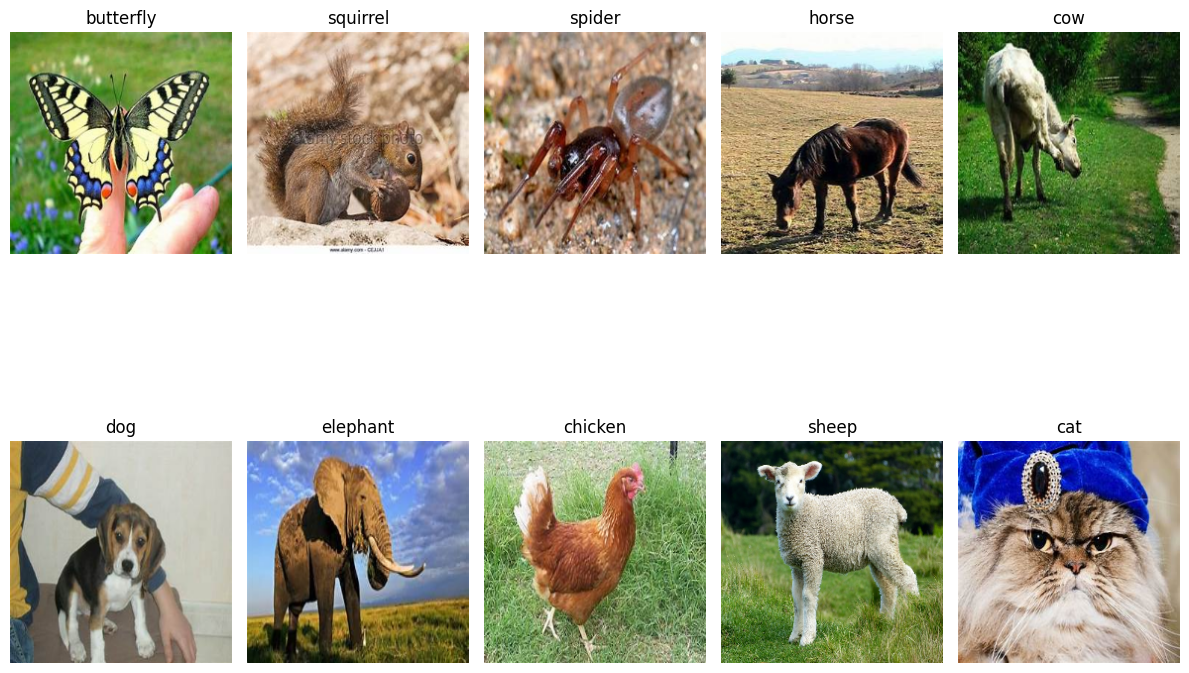

In [13]:
labels = train_df['label'].unique()

plt.figure(figsize=(12, 10))

for i, label in enumerate(labels):
  label_df = train_df[train_df['label'] == label]
  random_index = random.randint(0, len(label_df) - 1)

  image_path = label_df.iloc[random_index]['filename']
  image = plt.imread(image_path)
  image = cv2.resize(image, (224, 224))

  plt.subplot(2, 5, i+1)
  plt.imshow(image)
  plt.title(label)
  plt.axis('off')

plt.tight_layout()
plt.show()

### Data processing

In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

train_augmentation_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.5, 1.5],
)
train_gen = ImageDataGenerator(
    rescale=1./255
)

val_gen = ImageDataGenerator(
    rescale=1./255
)

test_gen = ImageDataGenerator(
    rescale=1./255
)

In [31]:
train_dataset = train_gen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_dataset = val_gen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_dataset = test_gen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 18325 validated image filenames belonging to 10 classes.
Found 3927 validated image filenames belonging to 10 classes.
Found 3927 validated image filenames belonging to 10 classes.


In [32]:
# visualizing some train data augmented

# images, labels = next(train_dataset)

# plt.figure(figsize=(12, 10))

# for i in range(15):
#   plt.subplot(3, 5, i+1)
#   plt.imshow(images[i])
#   label_index = np.argmax(labels[i])
#   label = list(train_dataset.class_indices.keys())[label_index]
#   plt.title(label)
#   plt.axis('off')

# plt.tight_layout()
# plt.show()

## Creating the models

### Setting up callbacks

In [67]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,
    verbose=1,
    restore_best_weights=True
)

# Model checkpoint
model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

### Base model

In [99]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, GlobalAveragePooling2D

In [35]:
base_model = Sequential([
    # 1st block
    Input(shape=(224, 224, 3)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2),

    # 2nd block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2),

    # 3rd block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2),

    # Flatten
    Flatten(),

    # Dense layer
    Dense(64, activation='relu'),
    Dropout(0.5),

    # output
    Dense(10, activation='softmax')
])

base_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

base_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │     6,422,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,517,386 (24.86 MB)

 Trainable params: 6,516,938 (24.86 MB)

 Non-trainable params: 448 (1.75 KB)

In [37]:
# Training the base model
base_history = base_model.fit(
    train_dataset,
    steps_per_epoch=len(train_dataset),
    epochs=20,
    validation_data=val_dataset,
    validation_steps=len(val_dataset),
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]
)

Epoch 1/20
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.1897 - loss: 2.2125
Epoch 1: val_loss improved from 2.21642 to 2.20838, saving model to best_model.keras
573/573 ━━━━━━━━━━━━━━━━━━━━ 47s 83ms/step - accuracy: 0.1897 - loss: 2.2125 - val_accuracy: 0.1841 - val_loss: 2.2084 - learning_rate: 0.0010
Epoch 2/20
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.1851 - loss: 2.2055
Epoch 2: val_loss improved from 2.20838 to 2.20764, saving model to best_model.keras
573/573 ━━━━━━━━━━━━━━━━━━━━ 48s 84ms/step - accuracy: 0.1851 - loss: 2.2055 - val_accuracy: 0.1841 - val_loss: 2.2076 - learning_rate: 0.0010
Epoch 3/20
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.1806 - loss: 2.2030
Epoch 3: val_loss improved from 2.20764 to 2.20753, saving model to best_model.keras
573/573 ━━━━━━━━━━━━━━━━━━━━ 46s 80ms/step - accuracy: 0.1806 - loss: 2.2030 - val_accuracy: 0.1859 - val_loss: 2.2075 - learning_rate: 0.0010
Epoch 4/20
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - 

In [63]:
def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(history.history['accuracy']))

  plt.figure(figsize=(12, 10))
  plt.subplot(2, 2, 1)
  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.subplot(2, 2, 2)
  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

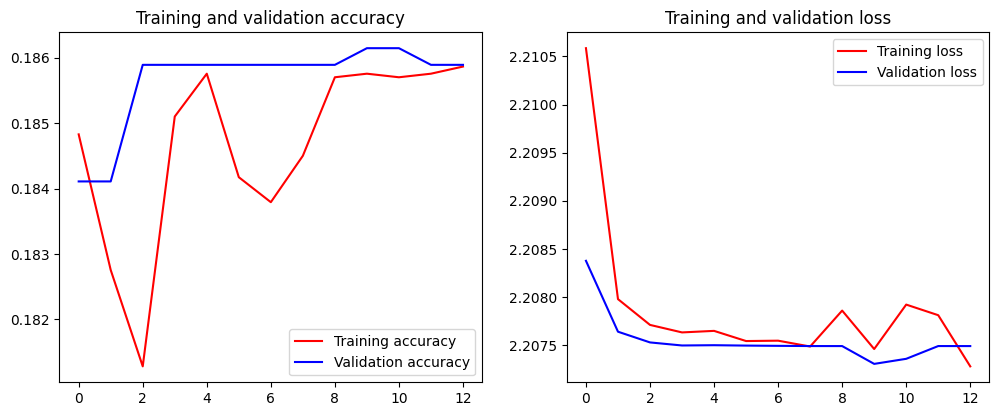

In [64]:
plot_history(base_history)

In [74]:
base_model.evaluate(val_dataset)

123/123 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - accuracy: 0.1865 - loss: 2.1999


[2.2073071002960205, 0.18614718317985535]

### Model 1 (with 20% of the dataset)

In [66]:
model_1 = Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(32, 3, activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(32, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64, 3, activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2),

    Flatten(),

    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model_1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │     6,422,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,563,946 (25.04 MB)

 Trainable params: 6,563,306 (25.04 MB)

 Non-trainable params: 640 (2.50 KB)

In [70]:
# Training the model 1
model_1_history = model_1.fit(
    train_dataset,
    steps_per_epoch=int(len(train_dataset)*0.2),
    epochs=20,
    validation_data=val_dataset,
    validation_steps=len(val_dataset),
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]
)

Epoch 1/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.1665 - loss: 2.2263
Epoch 1: val_loss did not improve from 2.20844
114/114 ━━━━━━━━━━━━━━━━━━━━ 21s 187ms/step - accuracy: 0.1666 - loss: 2.2262 - val_accuracy: 0.1836 - val_loss: 2.2145 - learning_rate: 0.0010
Epoch 2/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.2099 - loss: 2.2149
Epoch 2: val_loss did not improve from 2.20844
114/114 ━━━━━━━━━━━━━━━━━━━━ 22s 190ms/step - accuracy: 0.2098 - loss: 2.2149 - val_accuracy: 0.1841 - val_loss: 2.2189 - learning_rate: 0.0010
Epoch 3/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.1883 - loss: 2.2212
Epoch 3: val_loss did not improve from 2.20844

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
114/114 ━━━━━━━━━━━━━━━━━━━━ 21s 188ms/step - accuracy: 0.1882 - loss: 2.2212 - val_accuracy: 0.1808 - val_loss: 2.2935 - learning_rate: 0.0010
Epoch 4/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.1804 - loss: 2.211

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 6: val_loss did not improve from 2.20844
114/114 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - accuracy: 0.1345 - loss: 2.2549 - val_accuracy: 0.1836 - val_loss: 2.2086 - learning_rate: 5.0000e-04
Epoch 7/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.1815 - loss: 2.2054
Epoch 7: val_loss improved from 2.20844 to 2.20760, saving model to best_model.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 50s 189ms/step - accuracy: 0.1815 - loss: 2.2053 - val_accuracy: 0.1859 - val_loss: 2.2076 - learning_rate: 5.0000e-04
Epoch 8/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.1789 - loss: 2.2078
Epoch 8: val_loss improved from 2.20760 to 2.20759, saving model to best_model.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 22s 191ms/step - accuracy: 0.1790 - loss: 2.2078 - val_accuracy: 0.1859 - val_loss: 2.2076 - learning_rate: 5.0000e-04
Epoch 9/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.1672 - loss: 2.2086
Epoch 9: val_loss improved from 2.20759 to 2.20758, saving model to best_mod

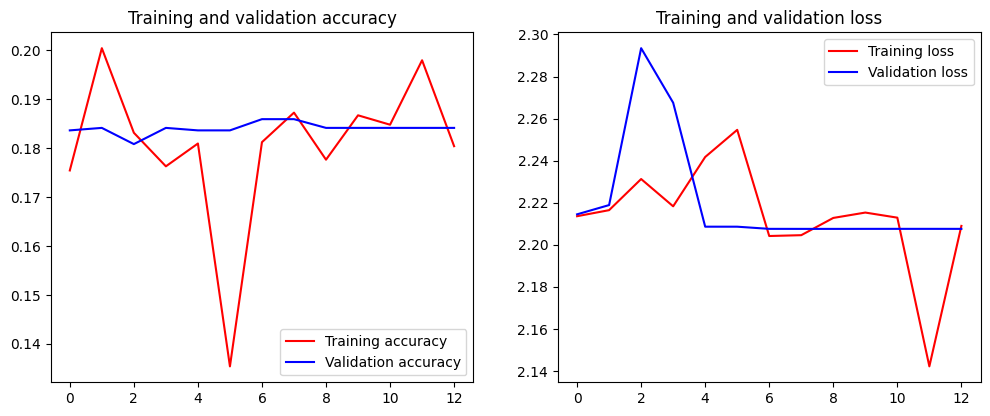

In [71]:
plot_history(model_1_history)

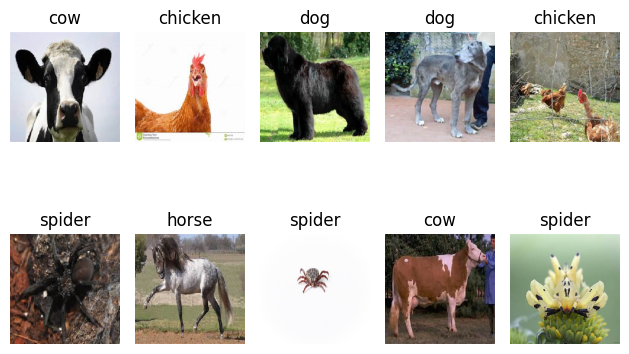

In [72]:
images, labels = next(test_dataset)

for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.imshow(images[i])
  plt.title(list(train_dataset.class_indices.keys())[np.argmax(labels[i])])
  plt.axis('off')

plt.tight_layout()
plt.show()

In [76]:
model_1.evaluate(val_dataset)

123/123 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.1929 - loss: 2.2011


[2.207583427429199, 0.18411000072956085]

In [86]:
from tensorflow.keras.models import load_model

model_1 = load_model('best_model.keras')

model_1.evaluate(val_dataset)

123/123 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.1929 - loss: 2.2011


[2.207583427429199, 0.18411000072956085]

### Model 2

In [100]:
model_2 = Sequential([
    Input(shape=(224,224,3)),

    Conv2D(32,3,activation='relu',padding='same'),
    BatchNormalization(),
    Conv2D(32,3,activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64,3,activation='relu',padding='same'),
    BatchNormalization(),
    Conv2D(64,3,activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128,3,activation='relu',padding='same'),
    BatchNormalization(),
    Conv2D(128,3,activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])


model_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_2.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_74 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_74          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_75 (Conv2D)              │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_75          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_76 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_76          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_77          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_78 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_78          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_79 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_79          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 356,010 (1.36 MB)

 Trainable params: 355,114 (1.35 MB)

 Non-trainable params: 896 (3.50 KB)

In [103]:
# Training the model
model_2_history = model_2.fit(
    train_dataset,
    steps_per_epoch=int(len(train_dataset)*0.2),
    epochs=20,
    validation_data=val_dataset,
    validation_steps=len(val_dataset),
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]
)

Epoch 1/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.3759 - loss: 1.7637
Epoch 1: val_loss did not improve from 1.90070
114/114 ━━━━━━━━━━━━━━━━━━━━ 24s 212ms/step - accuracy: 0.3759 - loss: 1.7636 - val_accuracy: 0.3201 - val_loss: 1.9070 - learning_rate: 0.0010
Epoch 2/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.3929 - loss: 1.7415
Epoch 2: val_loss improved from 1.90070 to 1.83089, saving model to best_model.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 27s 233ms/step - accuracy: 0.3928 - loss: 1.7416 - val_accuracy: 0.3461 - val_loss: 1.8309 - learning_rate: 0.0010
Epoch 3/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.3992 - loss: 1.6762
Epoch 3: val_loss did not improve from 1.83089
114/114 ━━━━━━━━━━━━━━━━━━━━ 24s 211ms/step - accuracy: 0.3992 - loss: 1.6762 - val_accuracy: 0.3163 - val_loss: 1.9454 - learning_rate: 0.0010
Epoch 4/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.4170 - loss: 1.6515
Epoch 4: val_loss improved from 1.830

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 6: val_loss improved from 1.63820 to 1.63472, saving model to best_model.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step - accuracy: 0.4995 - loss: 1.5260 - val_accuracy: 0.4214 - val_loss: 1.6347 - learning_rate: 0.0010
Epoch 7/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.4476 - loss: 1.5415
Epoch 7: val_loss did not improve from 1.63472
114/114 ━━━━━━━━━━━━━━━━━━━━ 24s 210ms/step - accuracy: 0.4477 - loss: 1.5414 - val_accuracy: 0.3754 - val_loss: 1.9316 - learning_rate: 0.0010
Epoch 8/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.4698 - loss: 1.5155
Epoch 8: val_loss did not improve from 1.63472

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
114/114 ━━━━━━━━━━━━━━━━━━━━ 24s 211ms/step - accuracy: 0.4698 - loss: 1.5154 - val_accuracy: 0.4184 - val_loss: 1.6726 - learning_rate: 0.0010
Epoch 9/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.4747 - loss: 1.4859
Epoch 9: val_loss did not improve from 1.63472
1

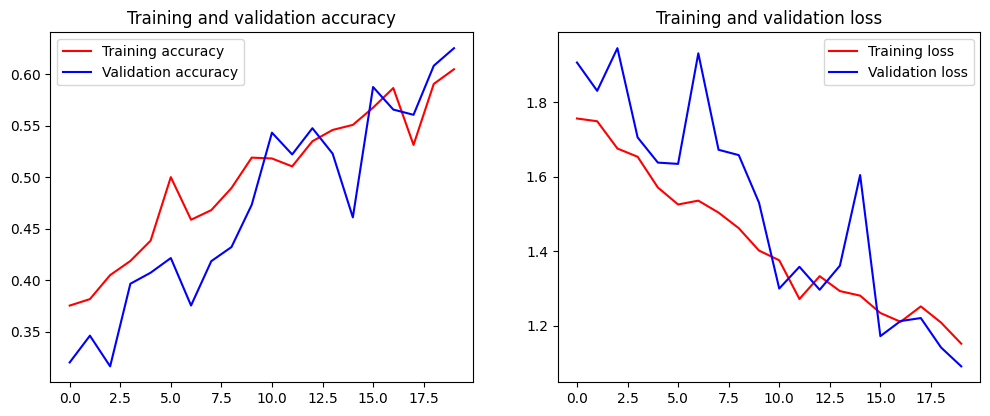

In [104]:
plot_history(model_2_history)

In [105]:
model_2.evaluate(val_dataset)

123/123 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.6217 - loss: 1.0803


[1.0910260677337646, 0.6251591444015503]

### Model 3

In [106]:
model_3 = Sequential([
    Input(shape=(224,224,3)),

    Conv2D(32,3,activation='relu',padding='same'),
    BatchNormalization(),
    Conv2D(32,3,activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64,3,activation='relu',padding='same'),
    BatchNormalization(),
    Conv2D(64,3,activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128,3,activation='relu',padding='same'),
    BatchNormalization(),
    Conv2D(128,3,activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(256,3,activation='relu',padding='same'),
    BatchNormalization(),
    Conv2D(256,3,activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])


model_3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_3.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_80 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_80          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_81 (Conv2D)              │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_81          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_82 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_82          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_83 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_83          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_84 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_84          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_85 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_85          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_86 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_86          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_87 (Conv2D)              │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_87          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             

 Total params: 1,283,690 (4.90 MB)

 Trainable params: 1,281,770 (4.89 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [107]:
model_3_history = model_3.fit(
    train_dataset,
    steps_per_epoch=len(train_dataset),
    epochs=20,
    validation_data=val_dataset,
    validation_steps=len(val_dataset),
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]
)

Epoch 1/20
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.2151 - loss: 2.1776
Epoch 1: val_loss did not improve from 1.09103
573/573 ━━━━━━━━━━━━━━━━━━━━ 126s 196ms/step - accuracy: 0.2152 - loss: 2.1774 - val_accuracy: 0.2709 - val_loss: 1.9694 - learning_rate: 0.0010
Epoch 2/20
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.3032 - loss: 1.9360
Epoch 2: val_loss did not improve from 1.09103
573/573 ━━━━━━━━━━━━━━━━━━━━ 101s 176ms/step - accuracy: 0.3033 - loss: 1.9359 - val_accuracy: 0.3061 - val_loss: 1.9257 - learning_rate: 0.0010
Epoch 3/20
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.3849 - loss: 1.7237
Epoch 3: val_loss did not improve from 1.09103
573/573 ━━━━━━━━━━━━━━━━━━━━ 101s 176ms/step - accuracy: 0.3849 - loss: 1.7236 - val_accuracy: 0.4212 - val_loss: 1.6650 - learning_rate: 0.0010
Epoch 4/20
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.4318 - loss: 1.5928
Epoch 4: val_loss did not improve from 1.09103
573/573 ━━━━━━━━━━━━━━━━━

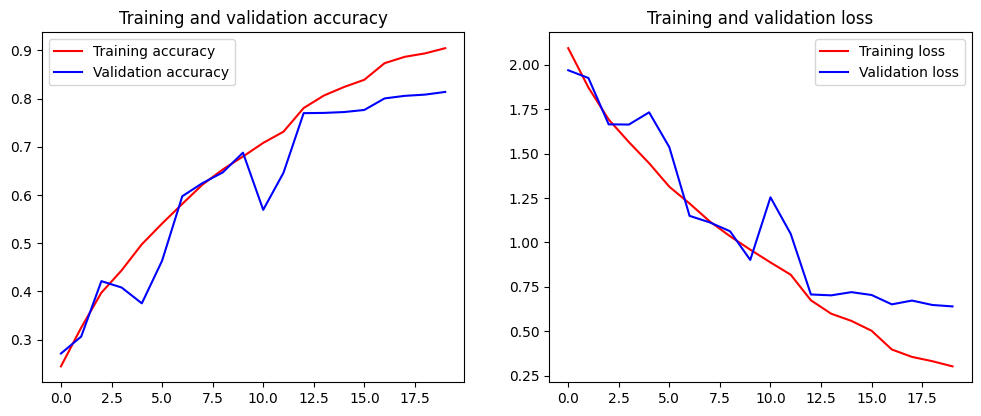

In [109]:
plot_history(model_3_history)

In [110]:
model_3.evaluate(val_dataset)

123/123 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.8167 - loss: 0.6476


[0.6402649283409119, 0.8138527870178223]

In [112]:
model_3 = load_model('best_model.keras')

model_3.evaluate(val_dataset)

123/123 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.8167 - loss: 0.6476


[0.6402649283409119, 0.8138527870178223]

### Model 4

In [118]:
model_4 = Sequential([
    Input(shape=(224,224,3)),

    Conv2D(32,3,activation='relu',padding='same'),
    BatchNormalization(),
    Conv2D(32,3,activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(64,3,activation='relu',padding='same'),
    BatchNormalization(),
    Conv2D(64,3,activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(128,3,activation='relu',padding='same'),
    BatchNormalization(),
    Conv2D(128,3,activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(256,3,activation='relu',padding='same'),
    BatchNormalization(),
    Conv2D(256,3,activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(512,3,activation='relu',padding='same'),
    BatchNormalization(),
    Conv2D(512,3,activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling2D(2),

    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])


model_4.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_4.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_108 (Conv2D)             │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_108         │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_109 (Conv2D)             │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_109         │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_59 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_110 (Conv2D)             │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_110         │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_111 (Conv2D)             │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_111         │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_60 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_112 (Conv2D)             │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_112         │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_113 (Conv2D)             │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_113         │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_61 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_114 (Conv2D)             │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_114         │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_115 (Conv2D)             │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_115         │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_62 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_116 (Conv2D)             │ (None, 14, 14, 512)    │     1,180,16

 Total params: 4,893,290 (18.67 MB)

 Trainable params: 4,889,322 (18.65 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [119]:
model_4_checkpoint = ModelCheckpoint(
    'model_4.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [120]:
model_4_history = model_4.fit(
    train_dataset,
    steps_per_epoch=len(train_dataset),
    epochs=20,
    validation_data=val_dataset,
    validation_steps=len(val_dataset),
    callbacks=[early_stopping, model_4_checkpoint, lr_scheduler]
)

Epoch 1/20
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.1861 - loss: 2.3110
Epoch 1: val_loss improved from inf to 2.10304, saving model to model_4.keras
573/573 ━━━━━━━━━━━━━━━━━━━━ 139s 217ms/step - accuracy: 0.1861 - loss: 2.3108 - val_accuracy: 0.2419 - val_loss: 2.1030 - learning_rate: 0.0010
Epoch 2/20
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.2704 - loss: 2.0680
Epoch 2: val_loss did not improve from 2.10304
573/573 ━━━━━━━━━━━━━━━━━━━━ 113s 198ms/step - accuracy: 0.2704 - loss: 2.0679 - val_accuracy: 0.1696 - val_loss: 2.8874 - learning_rate: 0.0010
Epoch 3/20
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.3126 - loss: 1.9113
Epoch 3: val_loss improved from 2.10304 to 1.81401, saving model to model_4.keras
573/573 ━━━━━━━━━━━━━━━━━━━━ 143s 199ms/step - accuracy: 0.3126 - loss: 1.9112 - val_accuracy: 0.3937 - val_loss: 1.8140 - learning_rate: 0.0010
Epoch 4/20
573/573 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.3829 - loss: 1.7342
Epoch 

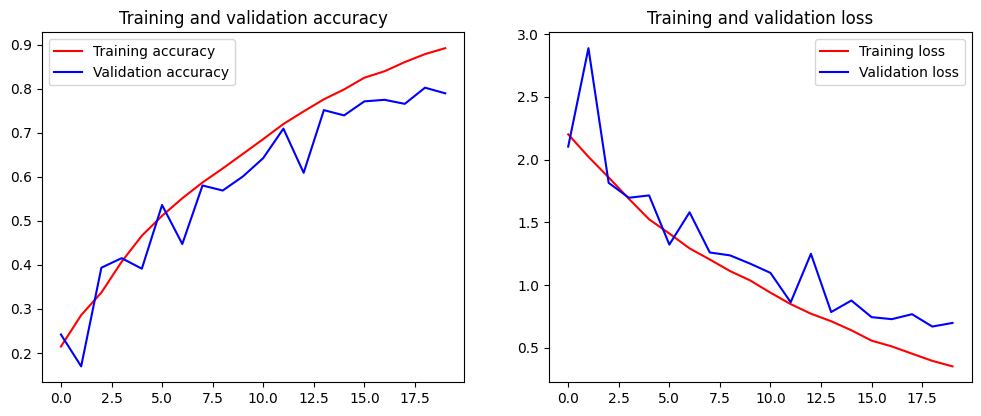

In [121]:
plot_history(model_4_history)

In [122]:
model_4.evaluate(val_dataset)

123/123 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.8032 - loss: 0.6677


[0.6684979796409607, 0.8023936748504639]